In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
RISK_FREE_RATE = 0.05       # 2% Annualized Risk Free Rate
TRANSACTION_COST = 0.001    # 0.1% per trade
MAX_TURNOVER = 0.10         # Limit weekly turnover to 10%
LOOKBACK_WEEKS = 1          # Use 1 week of data to estimate risk
RESAMPLE_FREQ = '15min'     # Resample 1-min data to 15-min to reduce noise


In [3]:
# ==========================================
# 2. DATA LOADING (Your Code)
# ==========================================
print("Loading data from CSVs...")

# Assuming your CSVs have columns like 'Open', 'High', 'Low', 'Close', 'Volume'
# We only need the 'Close' price for this optimization.

try:
    btc_data = pd.read_csv('BTCUSDC-1m-2years.csv', parse_dates=['timestamp'], index_col='timestamp')
    eth_data = pd.read_csv('ETHUSDC-1m-2years.csv', parse_dates=['timestamp'], index_col='timestamp')
    bnb_data = pd.read_csv('BNBUSDC-1m-2years.csv', parse_dates=['timestamp'], index_col='timestamp')
    xrp_data = pd.read_csv('XRPUSDC-1m-2years.csv', parse_dates=['timestamp'], index_col='timestamp')
    sol_data = pd.read_csv('SOLUSDC-1m-2years.csv', parse_dates=['timestamp'], index_col='timestamp')

    # --- MERGE DATA ---
    # We extract just the 'Close' column from each and combine them
    print("Merging data...")
    prices = pd.DataFrame({
        'BTC': btc_data['close'],
        'ETH': eth_data['close'],
        'BNB': bnb_data['close'],
        'XRP': xrp_data['close'],
        'SOL': sol_data['close']
    })

    # Handle missing data (if any timestamps don't match)
    prices = prices.fillna(method='ffill').dropna()

except FileNotFoundError:
    print("ERROR: CSV files not found. Creating DUMMY DATA for demonstration...")
    # --- DUMMY DATA GENERATOR (Fallback) ---
    #dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='1min')
    #data = np.random.normal(0.00001, 0.001, (len(dates), 5))
    #prices = pd.DataFrame((1 + data).cumprod(axis=0), index=dates, columns=['BTC','ETH','BNB','XRP','SOL'])


Loading data from CSVs...
Merging data...


/var/folders/1v/pvjy8h9d63x_z46tqdpl7p4h0000gn/T/ipykernel_11634/177172605.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.fillna(method='ffill').dropna()


In [4]:
# ==========================================
# 3. RESAMPLING & RETURNS
# ==========================================
print(f"Resampling data to {RESAMPLE_FREQ}...")

# Resample to 15-minute bars to get a cleaner covariance matrix
# (1-minute data is often too noisy for optimization)
prices.index = pd.to_datetime(prices.index, dayfirst=True)
prices = prices.sort_index()
prices_resampled = prices.resample(RESAMPLE_FREQ, label='right', closed='left').last()
returns_resampled = prices_resampled.pct_change().dropna()

tickers = returns_resampled.columns.tolist()
num_assets = len(tickers)

Resampling data to 15min...


In [5]:
# ==========================================
# 4. OPTIMIZATION FUNCTIONS
# ==========================================

def get_portfolio_metrics(weights, cov_matrix, mean_returns):
    """
    Calculates Annualized Return and Volatility
    """
    weights = np.array(weights)
    # Annualization factor for 15-min data 
    # (4 quarters/hr * 24 hr * 365 days = 35040)
    annual_factor = 35040 
    
    port_return = np.sum(mean_returns * weights) * annual_factor #we use the approx (1+r)^N = 1 + N*r for small r
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * annual_factor, weights)))
    
    return port_return, port_volatility

def objective_neg_sharpe(weights, cov_matrix, mean_returns, rf_rate):
    """
    Objective: Minimize Negative Sharpe Ratio
    """
    p_ret, p_vol = get_portfolio_metrics(weights, cov_matrix, mean_returns)
    if p_vol == 0: return 0
    return - (p_ret - rf_rate) / p_vol

def constraint_turnover(new_weights, current_weights, limit):
    """
    Constraint: Ensure turnover is within limit
    Limit - Actual_Turnover >= 0
    """
    turnover = np.sum(np.abs(new_weights - current_weights))
    return limit - turnover


In [6]:
# ==========================================
# 5. ROLLING BACKTEST (WEEKLY)
# ==========================================
print("Starting Weekly Optimization Loop...")

# Find all Fridays in the dataset for rebalancing
# We look for the last timestamp of every Friday
rebalance_dates = returns_resampled.index[
    (returns_resampled.index.dayofweek == 0) & 
    (returns_resampled.index.time >= pd.Timestamp("10:00").time())
]
# Use unique dates (just the days)
rebalance_dates = pd.Series(rebalance_dates).dt.date.unique()

# Initial Setup
# Lookback in bars (1 week * 7 days * 24 hours * 4 quarters = 672 bars)
lookback_bars = 672 * LOOKBACK_WEEKS

current_weights = np.array([1.0/num_assets] * num_assets) # Start Equal Weight
history = []

for i, date in enumerate(rebalance_dates):
    # Convert date back to timestamp for slicing
    ts = pd.Timestamp(date)
    
    # Locate the index in our dataframe
    # We find the insertion point to handle exact timestamp mismatches
    idx_loc = returns_resampled.index.searchsorted(ts)
    
    if idx_loc < lookback_bars:
        continue # Not enough history yet
        
    # SLICE THE DATA (The "Window")
    window_data = returns_resampled.iloc[idx_loc-lookback_bars : idx_loc]
    
    if window_data.empty:
        continue

    # CALCULATE METRICS FOR OPTIMIZER
    cov_matrix = window_data.cov()
    mean_returns = window_data.mean()
    
    # DEFINE CONSTRAINTS
    # 1. Weights sum to 1
    cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    # 2. Turnover Constraint (Relative to previous week's weights)
    cons.append({
        'type': 'ineq', 
        'fun': constraint_turnover, 
        'args': (current_weights, MAX_TURNOVER)
    })
    
    # 3. Bounds (-1.0 to 1.0 allows Short Selling)
    bounds = tuple((-1.0, 1.0) for _ in range(num_assets))

    # RUN OPTIMIZER
    result = minimize(
        objective_neg_sharpe,
        current_weights, # Start search from current weights (Warm Start)
        args=(cov_matrix, mean_returns, RISK_FREE_RATE),
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )
    
    if result.success:
        new_weights = result.x
    else:
        # If optimization fails, hold current position
        new_weights = current_weights

    # CALCULATE STATS
    turnover_pct = np.sum(np.abs(new_weights - current_weights))
    cost = turnover_pct * TRANSACTION_COST
    
    history.append({
        'Date': date,
        'Weights': new_weights,
        'Turnover': turnover_pct,
        'Transaction_Cost': cost
    })
    
    # Update for next loop
    current_weights = new_weights
    
    if i % 10 == 0:
        print(f"Processed week {i}/{len(rebalance_dates)}...")



Starting Weekly Optimization Loop...
Processed week 10/92...
Processed week 20/92...
Processed week 30/92...
Processed week 40/92...
Processed week 50/92...
Processed week 60/92...
Processed week 70/92...
Processed week 80/92...
Processed week 90/92...



BACKTEST PERFORMANCE REPORT
Total Return:          199.17%
Annualized Return:     89.92%
Annualized Volatility: 56.82%
Sharpe Ratio:          1.49
Max Drawdown:          -38.12%
Avg Weekly Turnover:   9.56%
Total Tx Costs:        0.86%
----------------------------------------


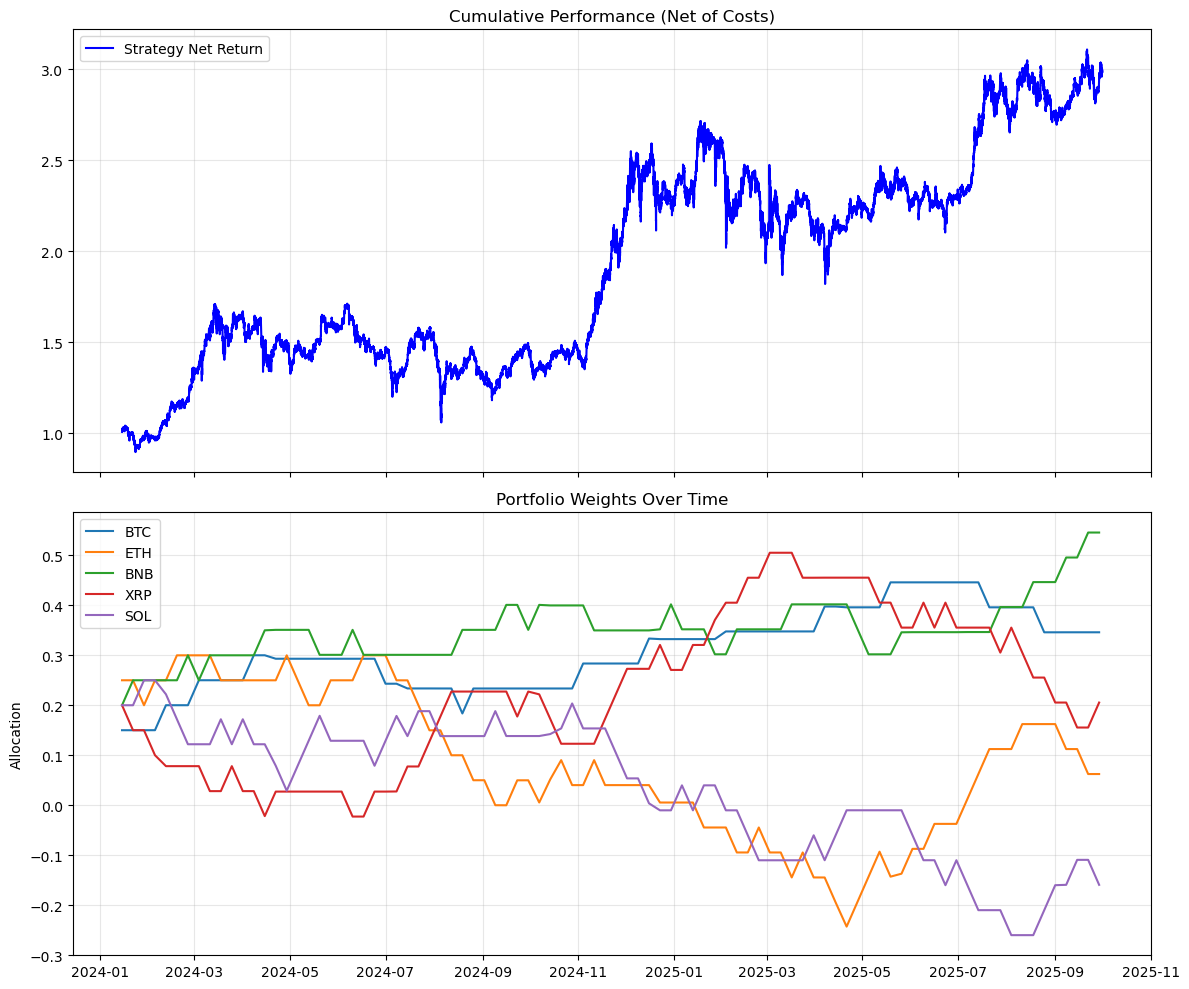

In [ ]:
# ==========================================
# 6. PERFORMANCE ANALYSIS (Fixed Part 6)
# ==========================================
if not history:
    print("No optimization performed.")
else:
    # 1. Prepare Dataframes
    results_df = pd.DataFrame(history).set_index('Date')
    weights_df = pd.DataFrame(results_df['Weights'].tolist(), index=results_df.index, columns=tickers)
    
    # 2. Reconstruct the Equity Curve (Walk-Forward)
    # We need to expand our weekly weights to match the 15-min returns frequency
    # ffill() means "carry this weight forward until a new weight appears"
    strat_weights = weights_df.reindex(returns_resampled.index).ffill()
    
    # SHIFT: Weights determined at T affect returns at T+1
    strat_weights = strat_weights.shift(1).dropna()
    
    # Match the returns to the same timeframe
    aligned_returns = returns_resampled.loc[strat_weights.index]
    
    # Calculate Gross Portfolio Return (Weighted Sum)
    # Axis=1 means sum across columns (BTC*w1 + ETH*w2 ...)
    strat_gross_ret = (aligned_returns * strat_weights).sum(axis=1)
    
    # 3. Apply Transaction Costs
    # Create a cost series matching the timeline (mostly zeros)
    cost_series = pd.Series(0.0, index=strat_gross_ret.index)
    
    # Map the costs from our optimization loop to the specific timestamps
    # Note: We align index types to ensure matching
    common_dates = results_df.index.intersection(cost_series.index)
    cost_series.loc[common_dates] = results_df.loc[common_dates, 'Transaction_Cost']
    
    # Net Return = Gross Return - Transaction Costs
    strat_net_ret = strat_gross_ret - cost_series

    # 4. Calculate Cumulative Performance
    cumulative_returns = (1 + strat_net_ret).cumprod()
    total_return = cumulative_returns.iloc[-1] - 1
    
    # 5. Calculate Annualized Metrics
    # Factor: 15-min bars per year = 4 * 24 * 365 = 35,040
    ANNUAL_FACTOR = 35040
    
    # Annualized Volatility
    ann_vol = strat_net_ret.std() * np.sqrt(ANNUAL_FACTOR)
    
    # Annualized Return (Compound Annual Growth Rate - CAGR)
    # We calculate the number of years in the data for accurate CAGR
    days_in_backtest = (strat_net_ret.index[-1] - strat_net_ret.index[0]).days
    years = days_in_backtest / 365.25
    ann_return = (1 + total_return) ** (1 / years) - 1
    
    # Sharpe Ratio
    sharpe_ratio = (ann_return - RISK_FREE_RATE) / ann_vol
    
    # Max Drawdown
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1.0
    max_drawdown = drawdown.min()

    # ==========================================
    # PRINT RESULTS
    # ==========================================
    print("\n" + "="*40)
    print("BACKTEST PERFORMANCE REPORT")
    print("="*40)
    print(f"Total Return:          {total_return:.2%}")
    print(f"Annualized Return:     {ann_return:.2%}")
    print(f"Annualized Volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio:          {sharpe_ratio:.2f}")
    print(f"Max Drawdown:          {max_drawdown:.2%}")
    print(f"Avg Weekly Turnover:   {results_df['Turnover'].mean():.2%}")
    print(f"Total Tx Costs:        {results_df['Transaction_Cost'].sum():.2%}")
    print("-" * 40)
    
    # ==========================================
    # PLOTTING
    # ==========================================
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Cumulative Returns
    ax1.plot(cumulative_returns.index, cumulative_returns, label='Strategy Net Return', color='blue')
    ax1.set_title('Cumulative Performance (Net of Costs)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Portfolio Weights Stacked
    for col in weights_df.columns:
        ax2.plot(weights_df.index, weights_df[col], label=col)
    ax2.set_title('Portfolio Weights Over Time')
    ax2.set_ylabel('Allocation')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()